In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

#df = pd.concat([dff[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex', 'text', 'y_sentence']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = pd.concat([dff[['text', 'y_sentence']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_sentence'])
df = df[df['y_sentence'] < 481]

In [4]:
X = df.drop('y_sentence', axis=1)
y = df['y_sentence']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

#X4_train =  X_train[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]
#X4_test =  X_test[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]

In [7]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [8]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (529,))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (662,))
#input_4 = tf.keras.Input(dtype = tf.float32, shape = (6,))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_3)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_3)


#dense_layer_4_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_4)
#dense_layer_4_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_1)
#dense_layer_4_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_2)
#dense_layer_4_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_3)
#dropout_4_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_4_4)

In [9]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

23324


In [10]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [11]:
#concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3, dropout_4_5])
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3])


dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)(dense_layer_4)

#model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)
model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output)

In [12]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.2), metrics=['mse', 'mae'])
print(model.summary())
#Adamax

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 128)     2985472     input_3[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 128, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 529)]        0                                            
______________________________________________________________________________________________

In [13]:
#history = model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.1)
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.1)

Train on 3193 samples, validate on 355 samples
Epoch 1/100
3193/3193 [==============================] - 4s 1ms/sample - loss: 1826.1471 - mse: 1802.7560 - mae: 20.5982 - val_loss: 1357.1740 - val_mse: 1330.0988 - val_mae: 19.9850
Epoch 2/100
3193/3193 [==============================] - 1s 329us/sample - loss: 1572.5600 - mse: 1542.8478 - mae: 19.9924 - val_loss: 1259.6684 - val_mse: 1227.1072 - val_mae: 17.7879
Epoch 3/100
3193/3193 [==============================] - 1s 327us/sample - loss: 1405.6232 - mse: 1368.8038 - mae: 18.6680 - val_loss: 1165.9252 - val_mse: 1125.2985 - val_mae: 17.41261282.6187 - mae: 18.30 - ETA: 0s - loss: 1308.2655 - mse: 1272.3362 - mae: 18.34 - ETA: 0s - loss: 1337.2351 - mse: 1301.1141 - mae: 1
Epoch 4/100
3193/3193 [==============================] - 1s 327us/sample - loss: 1273.9557 - mse: 1229.4148 - mae: 17.7002 - val_loss: 1114.7258 - val_mse: 1068.2961 - val_mae: 16.6729
Epoch 5/100
3193/3193 [==============================] - 1s 326us/sample - loss: 

3193/3193 [==============================] - 1s 327us/sample - loss: 417.6599 - mse: 297.7533 - mae: 10.4457 - val_loss: 883.4886 - val_mse: 763.1492 - val_mae: 13.7020
Epoch 42/100
3193/3193 [==============================] - 1s 328us/sample - loss: 423.7589 - mse: 303.3272 - mae: 10.3450 - val_loss: 898.5761 - val_mse: 777.9124 - val_mae: 13.6021
Epoch 43/100
3193/3193 [==============================] - 1s 329us/sample - loss: 404.8728 - mse: 283.8014 - mae: 10.2781 - val_loss: 881.2643 - val_mse: 760.3239 - val_mae: 13.7197
Epoch 44/100
3193/3193 [==============================] - 1s 329us/sample - loss: 408.9943 - mse: 287.8139 - mae: 10.1833 - val_loss: 910.8398 - val_mse: 790.0472 - val_mae: 13.5925
Epoch 45/100
3193/3193 [==============================] - 1s 328us/sample - loss: 417.1819 - mse: 296.3534 - mae: 10.1572 - val_loss: 858.3568 - val_mse: 737.0627 - val_mae: 13.7782 405.7869 - mse: 
Epoch 46/100
3193/3193 [==============================] - 1s 338us/sample - loss: 384.

3193/3193 [==============================] - 1s 327us/sample - loss: 233.8097 - mse: 137.3165 - mae: 7.6969 - val_loss: 846.8855 - val_mse: 750.9529 - val_mae: 13.3419
Epoch 82/100
3193/3193 [==============================] - 1s 327us/sample - loss: 229.7148 - mse: 133.8976 - mae: 7.3498 - val_loss: 860.1763 - val_mse: 764.8557 - val_mae: 13.4414
Epoch 83/100
3193/3193 [==============================] - 1s 329us/sample - loss: 221.5035 - mse: 126.4695 - mae: 7.3582 - val_loss: 820.8079 - val_mse: 726.3622 - val_mae: 13.5409
Epoch 84/100
3193/3193 [==============================] - 1s 328us/sample - loss: 233.7340 - mse: 139.6343 - mae: 7.5468 - val_loss: 779.4778 - val_mse: 685.6959 - val_mae: 13.9827
Epoch 85/100
3193/3193 [==============================] - 1s 326us/sample - loss: 226.5802 - mse: 133.3046 - mae: 7.5182 - val_loss: 784.9390 - val_mse: 691.8125 - val_mae: 13.6857
Epoch 86/100
3193/3193 [==============================] - 1s 328us/sample - loss: 215.3185 - mse: 122.5228 -

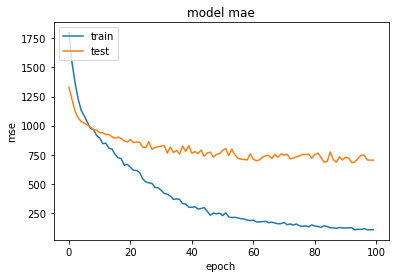

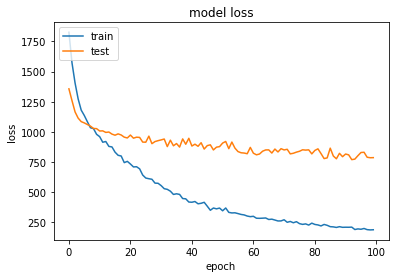

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mae')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
#score = model.evaluate(x=[X1_test, X2_test, X3_test, X4_test], y=y_test, verbose=1)
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)

print(score)
print("Test Score:", score[0])
print("Test MSE:", score[1])
print("Test MAE: ", score[2])

395/395 [==============================] - 0s 281us/sample - loss: 414.0207 - mse: 330.9156 - mae: 11.0567
[414.0207319428649, 330.91565, 11.056707]
Test Score: 414.0207319428649
Test MSE: 330.91565
Test MAE:  11.056707


In [16]:
#tf-idf 0.2
#10-10-10-10 배치 16, 에폭 100, Adamax 0.001: 393 392 <===
#50-10-10-10 배치 16, 에폭 100, Adamax 0.001: 528
#100-100-100-100 배치 16, 에폭 100, Adamax 0.001: 813
#8-8-8-8 배치 16, 에폭 100, Adamax 0.001: 407
#12-12-12-12 배치 16, 에폭 100, Adamax 0.001: 616

#10-10-10-10 배치 2, 에폭 100, Adamax 0.001: 594
#10-10-10-10 배치 32, 에폭 100, Adamax 0.001:358 364 <== 에폭 50: 360 358 
#10-10-10-10 배치 64, 에폭 100, Adamax 0.001: 374
#10-10-10-10 배치 128, 에폭 100, Adamax 0.001: 369

#10-10-10-10 배치 32, 에폭 100, Adamax 0.0001: 505// 에폭 200: 425// 에폭 300: 387// 에폭 400: 371// 에폭 500:371 // 에폭 600: 367
#10-10-10-10 배치 32, 에폭 100, Adamax 0.0005: 362 363기울기가 더 그럴 듯 하다. // 에폭 200 : 359 
#10-10-10-10 배치 32, 에폭 100, Adamax 0.005: 435
#10-10-10-10 배치 32, 에폭 100, Adamax 0.01: 586


#10-10-10-10 배치 32, 에폭 100, Adam 0.001: 461 그래프 못 생김

#10-10-10-10 배치 32, 에폭 100, Adamax 0.0005, 판사 없이: 346 344 343 //애폭 120: 341 370//에폭150: 347 365 361 //에폭 400: 414
#10-10-10-10 배치 32, 에폭 100, Adamax 0.001, 판사 없이: 350 // 에폭400: 534
#10-10-10-10 배치 32, 에폭 100, RMSProp 0.001, 판사 없이: 621
#10-10-10-10 배치 32, 에폭 100, RMSProp 0.0005, 판사 없이: 664
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.001, 판사 없이: 779 //에폭200: 703
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.01, 판사 없이:580 
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.1, 판사 없이: 408
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.15, 판사 없이: 368
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 329 334 334 334 335<==================에폭 120: 363// 에폭 80: 351
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.25, 판사 없이: 405
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.3, 판사 없이: 360 360 365 

#10-10-10-10 배치 32, 에폭 100, Adagrad 0.001, 판사 없이: 498
#10-10-10-10 배치 32, 에폭 100, Adagrad 0.005, 판사 없이: 412
#10-10-10-10 배치 32, 에폭 100, Adagrad 0.01, 판사 없이: 394
#10-10-10-10 배치 32, 에폭 100, Adagrad 0.05, 판사 없이: 404

#10-10-10-10 배치 32, 에폭 100, Nadam 0.005, 판사 없이: 494
#10-10-10-10 배치 32, 에폭 100, Nadam 0.001, 판사 없이: 504
#10-10-10-10 배치 32, 에폭 100, Nadam 0.0005, 판사 없이: 388
#10-10-10-10 배치 32, 에폭 100, Nadam 0.0001, 판사 없이: 406



#tf-idf 0.1
#10-10-10-10 배치 32, 에폭 100, Adamax 0.0005, 판사 없이: 687

#마지막 10 에러 고치고
#마지막 10-10-10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 477
#마지막 10-10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 488
#마지막 10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이:367
#전체 10 -10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 332 328 <===========================에폭200: 476
#10-10-(10) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 338 336 332 330 <==============================에폭 120: 360
#512-512-(512) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 926
#256-256-(256) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이:884
#128-128-(128) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이:880
#20-20-(20) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 418
#50-10-(10) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 497

